## Background

Heart disease is a critical health issue affecting millions worldwide. Patient data provides valuable insights into identifying risk factors and predicting outcomes. This project aims to analyze and predict the risk of heart disease using a multiclass classifier, leveraging patient data such as age, blood pressure, cholesterol levels, and other health metrics.

## Import Library & Data

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler,LabelEncoder 
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import SMOTE 
import pickle

In [2]:
df = pd.read_csv('heart.csv')
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
838,63,M,ASY,130,330,1,LVH,132,Y,1.8,Up,1
635,67,M,ASY,120,229,0,LVH,129,Y,2.6,Flat,1
667,65,F,NAP,140,417,1,LVH,157,N,0.8,Up,0
887,43,M,ASY,132,247,1,LVH,143,Y,0.1,Flat,1
584,64,M,ASY,141,244,1,ST,116,Y,1.5,Flat,1


## Data Understanding

In [3]:
print('Data Shape :',df.shape)

Data Shape : (918, 12)


In [4]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [7]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

## Data Cleaning

In [8]:
print('Data Shape :',df.shape)

Data Shape : (918, 12)


In [9]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
print('Data Shape :',df.shape)

Data Shape : (918, 12)


## Exploratory Data Analysis (EDA)

In [13]:
df['Sex'] = df['Sex'].map({'M':'Male', 'F':'Female'})
df['ChestPainType'] = df['ChestPainType'].map({'TA':'Typical Angina', 'ATA':'Atypical Angina', 
                                               'NAP' : 'Non-Anginal Pain', 'ASY' : 'Asymptomatic'})
df['FastingBS'] = df['FastingBS'].map({1: '> 120 mg/dl', 0: '<= 120 mg/dl'})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 'Yes', 'N': 'No'})
df['HeartDisease'] = df['HeartDisease'].map({1: 'Yes', 0: 'No'})

### What Happened?

In [14]:
import plotly.express as px
import plotly.graph_objects as go

def plot_interactive_heart_disease(df):
    # Bar Chart with Annotations
    bar_fig = px.bar(
        df['HeartDisease'].value_counts().reset_index(),
        x='index',
        y='HeartDisease',
        labels={'index': 'Heart Disease', 'HeartDisease': 'Count'},
        color='index',
        title='Heart Disease Count'
    )
    bar_fig.update_traces(texttemplate='%{y}', textposition='outside')
    bar_fig.update_layout(showlegend=False, xaxis_title=None)

    # Pie Chart
    pie_fig = go.Figure(data=[go.Pie(
        labels=df['HeartDisease'].value_counts().index,
        values=df['HeartDisease'].value_counts().values,
        hole=0.4,
        textinfo='percent+label',
        hoverinfo='label+value+percent'
    )])
    pie_fig.update_layout(title='Heart Disease Distribution', showlegend=True)

    # Show both charts
    bar_fig.show()
    pie_fig.show()

# Example usage:
# Assuming 'df' is your DataFrame with a 'HeartDisease' column
plot_interactive_heart_disease(df)

The dataset contains 508 instances (55.3%) labeled as "Heart Disease" and 410 instances (44.7%) labeled as "No Heart Disease."

### How does the prevalence of heart disease vary by age and gender?

In [15]:
male = df[df['Sex'] == 'Male'] 
female = df[df['Sex'] == 'Female'] 

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Subplots untuk pie chart pria dan wanita
fig = make_subplots(
    rows=1, cols=2,  # 1 baris, 2 kolom
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],  # Domain digunakan untuk pie chart
    subplot_titles=['Male', 'Female']
)

# Data untuk pria
fig.add_trace(
    go.Pie(
        labels=male['HeartDisease'].value_counts().index,
        values=male['HeartDisease'].value_counts().values,
        hole=0.4,
        textinfo='percent+label',
        hoverinfo='label+value+percent',
        marker=dict(colors=['#EF553B','#636EFA'])
    ),
    row=1, col=1  # Posisi subplot
)

# Data untuk wanita
fig.add_trace(
    go.Pie(
        labels=female['HeartDisease'].value_counts().index,
        values=female['HeartDisease'].value_counts().values,
        hole=0.4,
        textinfo='percent+label',
        hoverinfo='label+value+percent',
        marker=dict(colors=['#00CC96', '#FFA15A'])
    ),
    row=1, col=2  # Posisi subplot
)

# Menambahkan layout
fig.update_layout(
    title_text='Heart Disease Distribution: Male vs Female',
    title_font_size=20,
    showlegend=True
)

fig.show()


Males typically show a higher prevalence of heart disease compared to females.

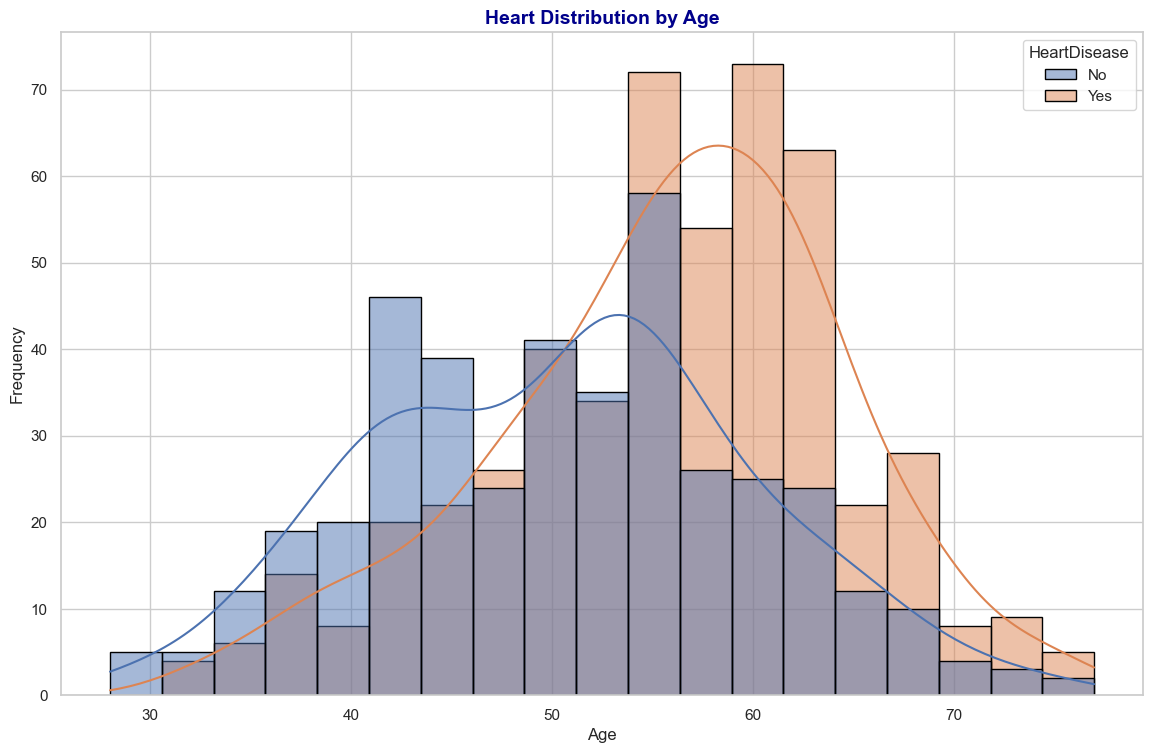

In [17]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.histplot(data=df, x='Age', hue='HeartDisease',kde=True, color="skyblue", edgecolor="black",multiple='layer')
# sns.kdeplot(data=df['Age'], ax=ax, color='darkblue', linewidth=2)  # Custom KDE line color and thickness
    
# Title and labels customization
plt.title('Heart Distribution by Age', fontsize=14, fontweight='bold', color='darkblue')
plt.xlabel('Age', fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Adjust layout and display
plt.tight_layout(pad=2)
plt.show()

Heart disease is more prevalent among older individuals, with an increasing trend after age 40.

### What are the most common chest pain types (ChestPainType) among patients with and without heart disease?

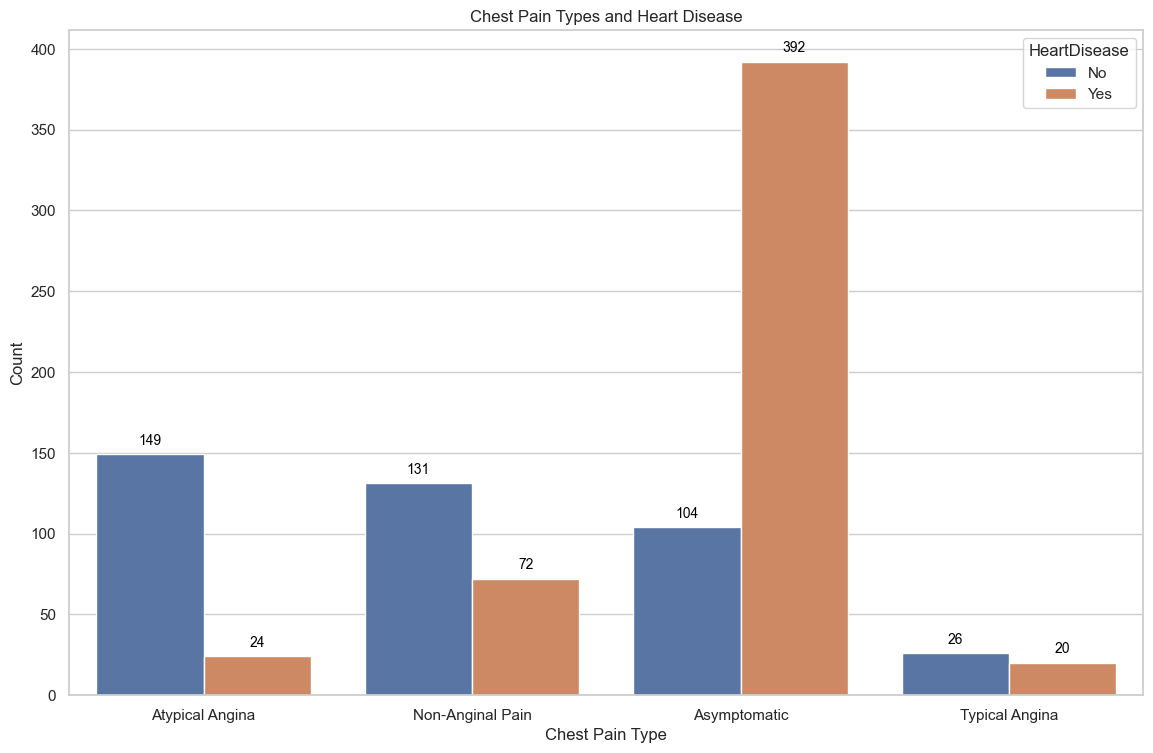

In [18]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.countplot(data=df, x="ChestPainType", hue="HeartDisease")
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
plt.title("Chest Pain Types and Heart Disease")
plt.xlabel("Chest Pain Type")
plt.ylabel("Count")
plt.tight_layout(pad=2)
plt.show()

- Patients with atypical angina, non-anginal and Typical angina chest pain tend to have lower rates of heart disease.
- asymptomatic chest pain is often linked with higher heart disease prevalence.

### What is the relationship between resting blood pressure (RestingBP), cholesterol (Cholesterol), and heart disease prevalence?

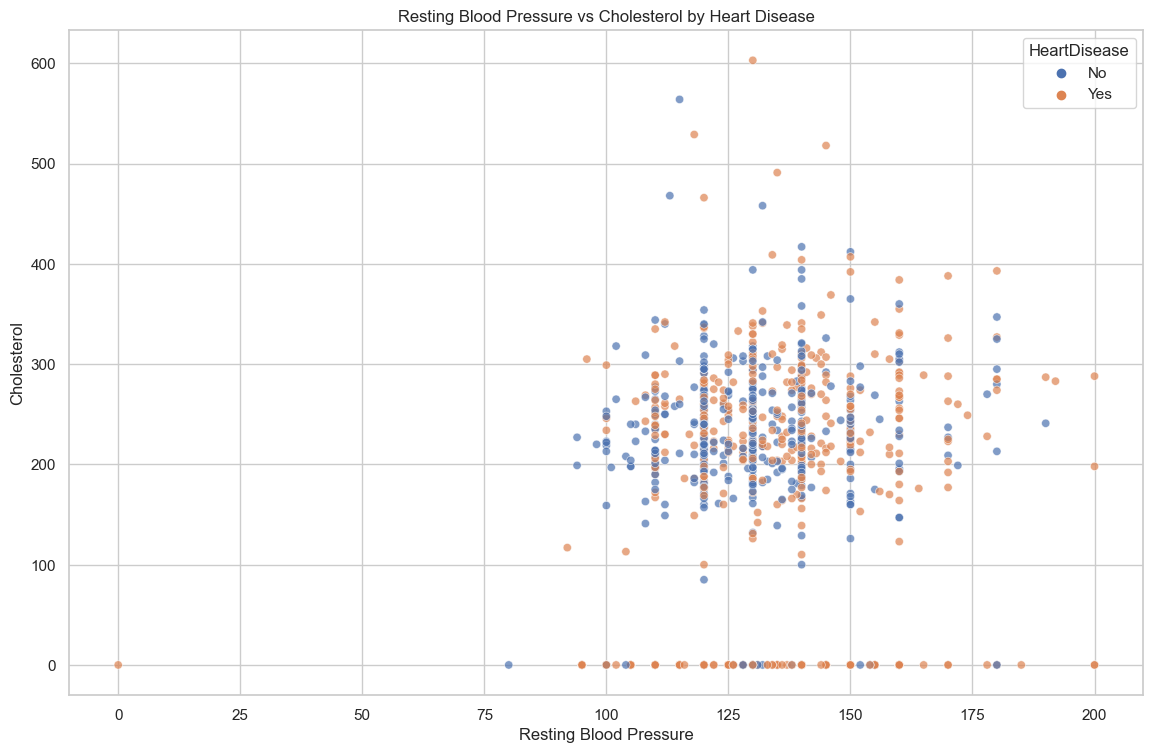

In [19]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.scatterplot(data=df, x="RestingBP", y="Cholesterol", hue="HeartDisease", alpha=0.7)
plt.title("Resting Blood Pressure vs Cholesterol by Heart Disease")
plt.xlabel("Resting Blood Pressure")
plt.ylabel("Cholesterol")
plt.tight_layout(pad=2)
plt.show()

Higher cholesterol and elevated resting blood pressure are associated with a greater likelihood of heart disease, but the relationship may vary depending on other factors like age.

### How does the maximum heart rate achieved (MaxHR) differ between patients with and without exercise-induced angina (ExerciseAngina)?

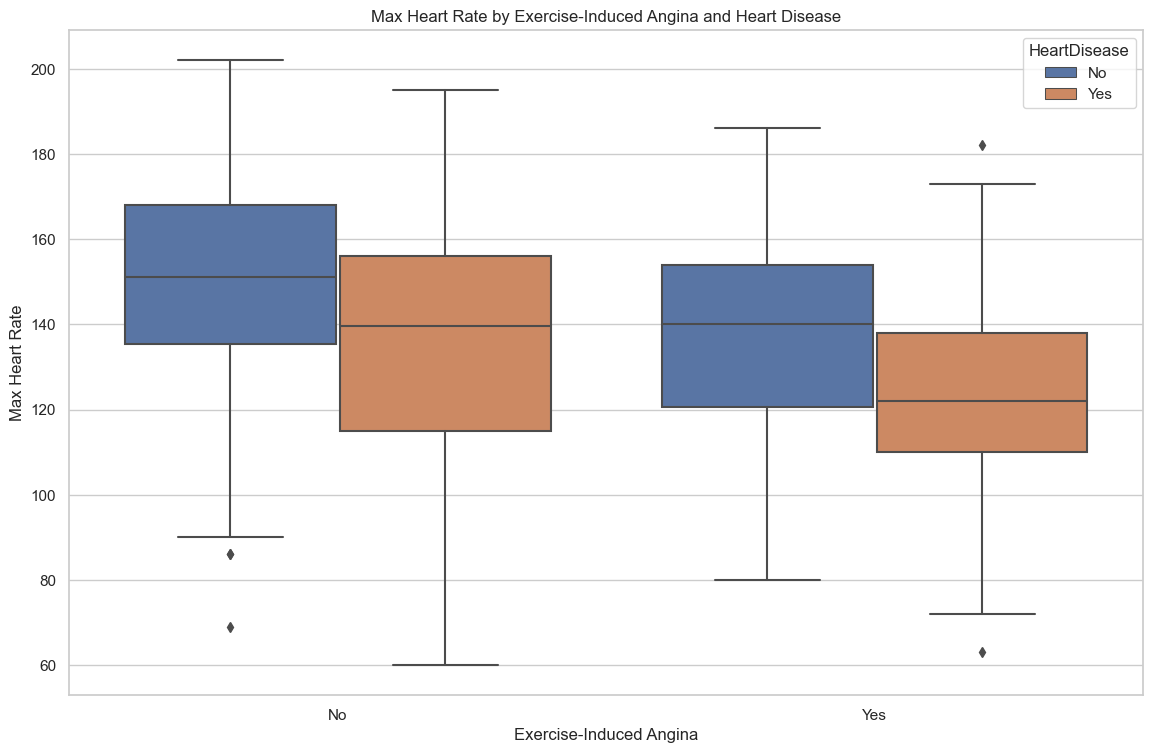

In [20]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.boxplot(data=df, x="ExerciseAngina", y="MaxHR", hue="HeartDisease")
plt.title("Max Heart Rate by Exercise-Induced Angina and Heart Disease")
plt.xlabel("Exercise-Induced Angina")
plt.ylabel("Max Heart Rate")
plt.tight_layout(pad=2)
plt.show()

Individuals with heart disease tend to have a lower Max Heart Rate compared to those without heart disease, regardless of whether they experience Exercise-Induced Angina or not.

### What patterns in resting ECG (RestingECG) and ST segment slope (ST_Slope) are associated with heart disease?

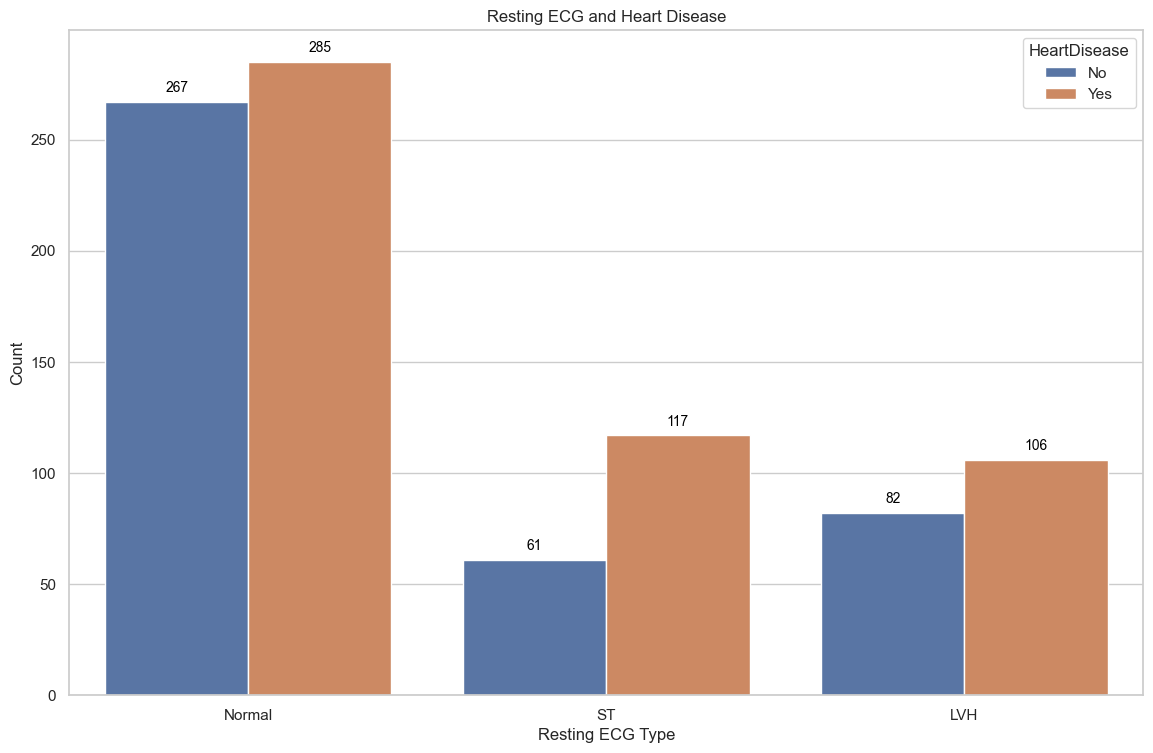

In [21]:
# Set the figure size and background style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.countplot(data=df, x="RestingECG", hue="HeartDisease")
plt.title("Resting ECG and Heart Disease")
plt.xlabel("Resting ECG Type")
plt.ylabel("Count")
# Adding count labels on top of each bar
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
# Adjust layout to avoid overlap and display
plt.tight_layout(pad=2)
plt.show()

Abnormal resting ECG results are more common in heart disease cases.

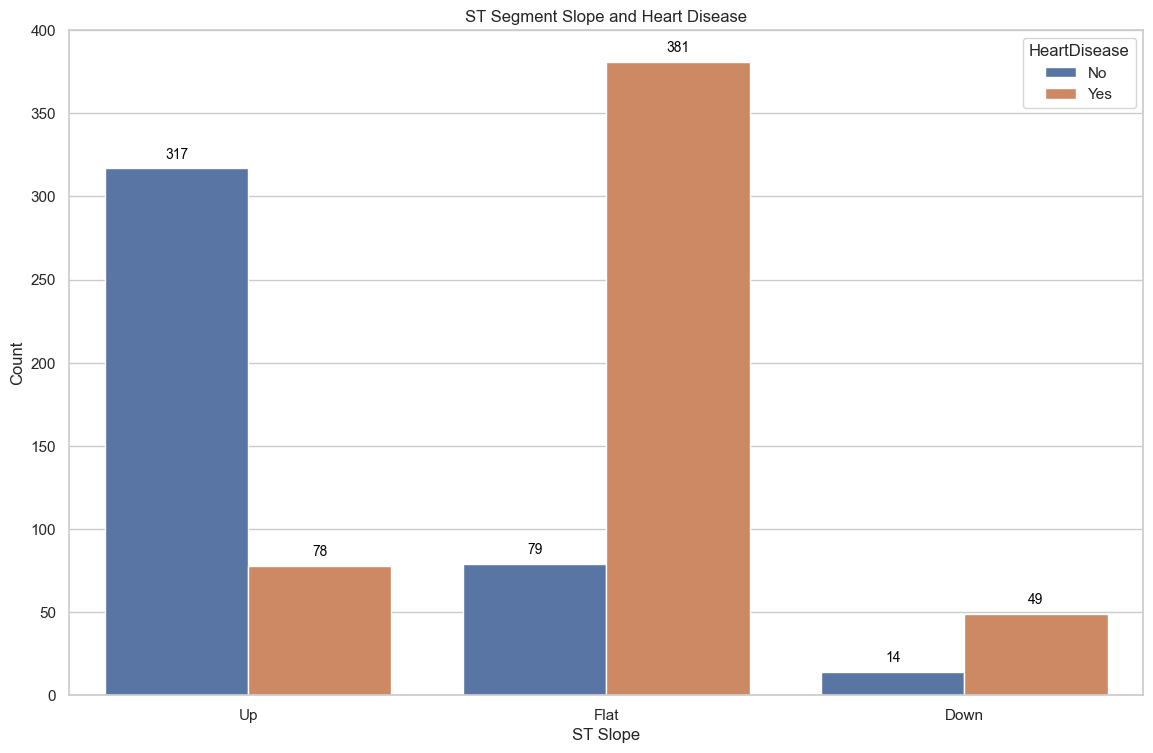

In [22]:
# Set the figure size and background style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.countplot(data=df, x="ST_Slope", hue="HeartDisease")
plt.title("ST Segment Slope and Heart Disease")
plt.xlabel("ST Slope")
plt.ylabel("Count")
# Adding count labels on top of each bar
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
# Adjust layout to avoid overlap and display
plt.tight_layout(pad=2)
plt.show()

A descending ST segment slope is strongly associated with heart disease.

### How do age and fasting blood sugar (FastingBS) together influence the likelihood of heart disease?

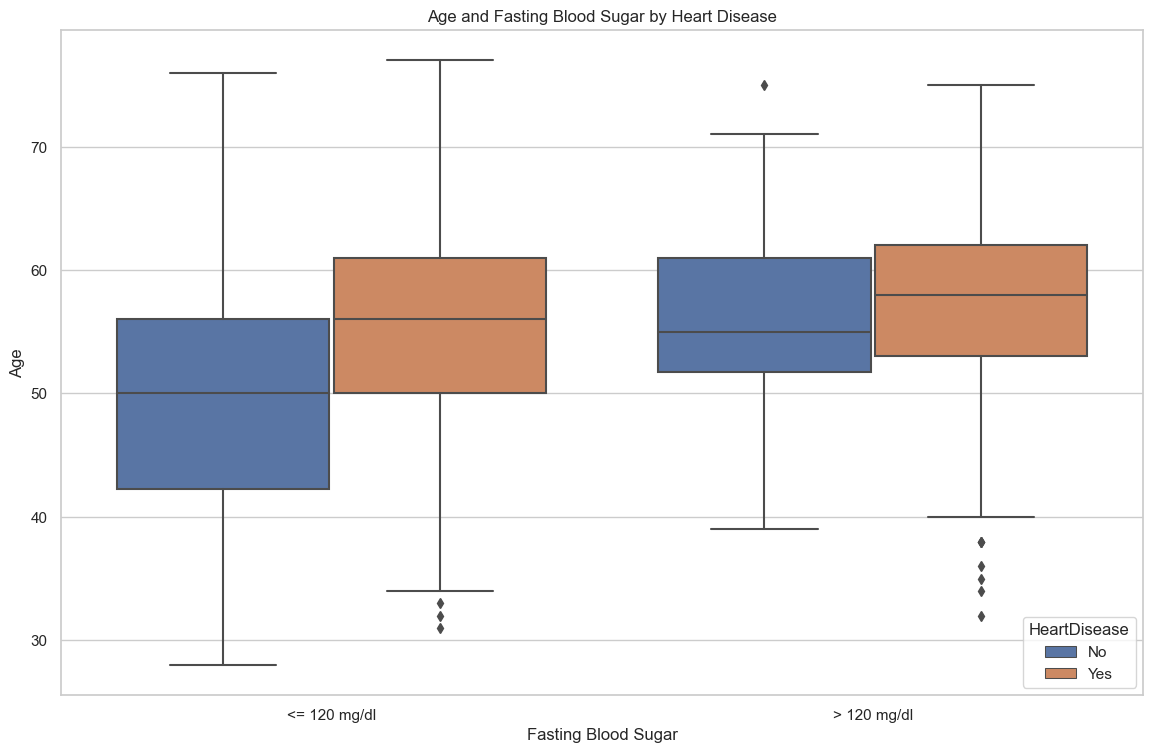

In [23]:
# Set the figure size and background style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.boxplot(data=df, x="FastingBS", y="Age", hue="HeartDisease")
plt.title("Age and Fasting Blood Sugar by Heart Disease")
plt.xlabel("Fasting Blood Sugar")
plt.ylabel("Age")
plt.tight_layout(pad=2)
plt.show()

Older individuals with fasting blood sugar > 120 mg/dl have a significantly higher prevalence of heart disease.

### Are there any notable outliers in Age, RestingBP, Cholesterol, MaxHR, or Oldpeak?

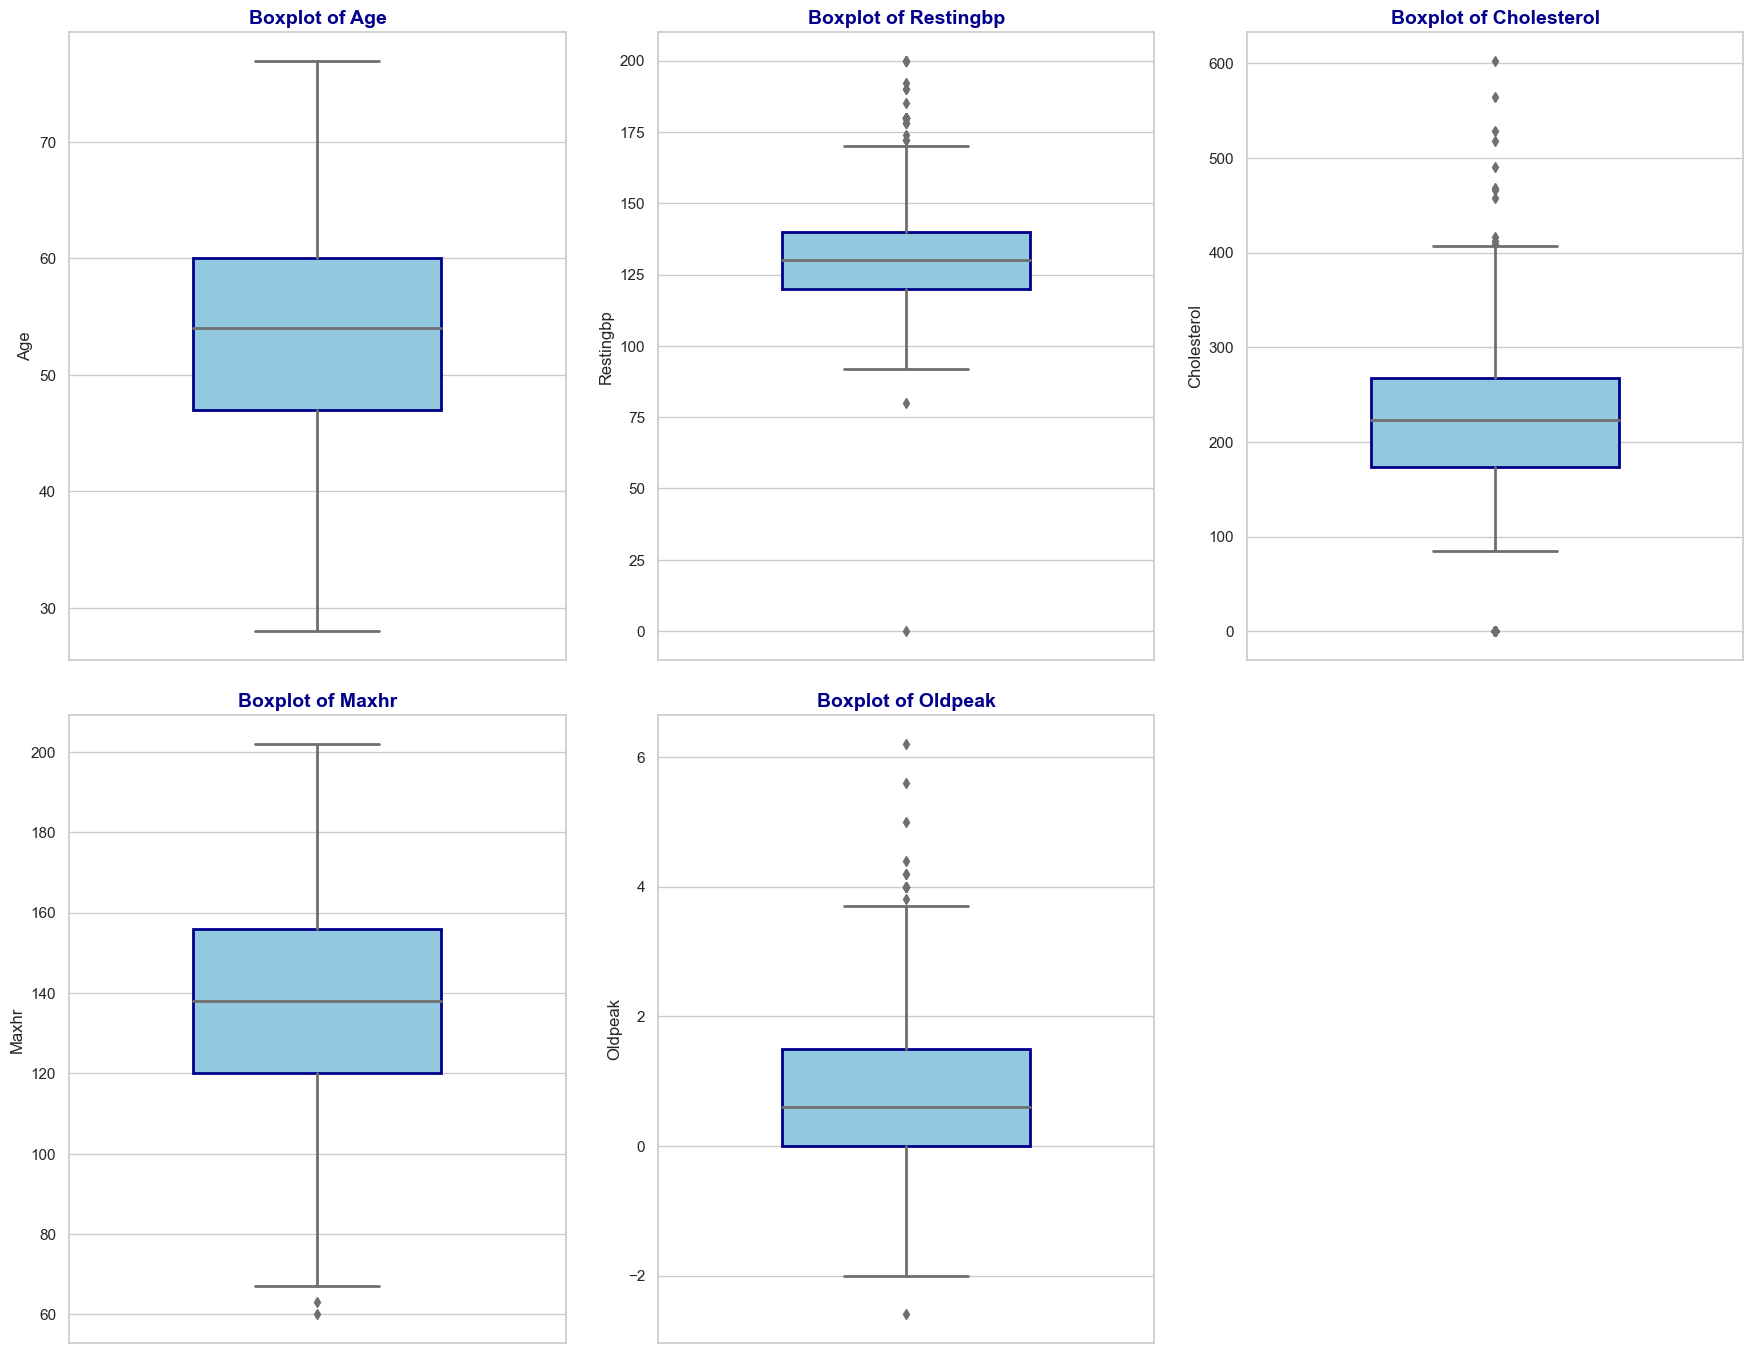

In [24]:
Column_Numerics = df.select_dtypes(include=['number'])
# Set figure size and background style
plt.figure(figsize=(18, 14))
sns.set(style="whitegrid")

# Loop through each column and create boxplots with customization
for i, col in enumerate(Column_Numerics, 1):
    plt.subplot(2, 3, i)  # Create a 3x3 grid layout
    ax = sns.boxplot(data=df, y=col, color="skyblue", width=0.5, linewidth=2, fliersize=5, boxprops=dict(edgecolor="darkblue"))
    
    # Title and labels customization
    plt.title(f'Boxplot of {col.replace("_", " ").title()}', fontsize=14, fontweight='bold', color='darkblue')
    plt.ylabel(col.replace("_", " ").title(), fontsize=12)
    plt.xlabel("")

# Adjust layout and display
plt.tight_layout(pad=2)
plt.show()

Based on the boxplot, the columns **RestingBP**, **Cholesterol**, **MaxHR**, and **Oldpeak** contain outliers that should be removed to maintain data quality.

In [25]:
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)  # Kuartil pertama
        Q3 = df[column].quantile(0.75)  # Kuartil ketiga
        IQR = Q3 - Q1  # Rentang antar-kuartil
        
        # Batas bawah dan atas
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Hanya menyimpan data yang berada dalam batas
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
# remove outlier
print('Data Shape before remove_outliers_iqr: ',df.shape)
df = remove_outliers_iqr(df, Column_Numerics)
print('Data Shape after remove_outliers_iqr: ',df.shape)

Data Shape before remove_outliers_iqr:  (918, 12)
Data Shape after remove_outliers_iqr:  (701, 12)


## Feature Extraction

In [26]:
Column_Categories = df.select_dtypes(include=['object'])
print(Column_Categories.columns)

Index(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
       'ST_Slope', 'HeartDisease'],
      dtype='object')


In [ ]:
le = LabelEncoder()
# HeartDisease = {'Heart Disease': 1, 'Normal': 0}
# df['HeartDisease'] = df['HeartDisease'].map(HeartDisease)
for column in Column_Categories:
    df[column] = le.fit_transform(df[column])
    for i, atribut in enumerate(le.classes_):
        print(f'The attribute of {column} -> "{atribut}" is converted to: {i}')

The attribute of Sex -> "Female" is converted to: 0
The attribute of Sex -> "Male" is converted to: 1
The attribute of ChestPainType -> "Asymptomatic" is converted to: 0
The attribute of ChestPainType -> "Atypical Angina" is converted to: 1
The attribute of ChestPainType -> "Non-Anginal Pain" is converted to: 2
The attribute of ChestPainType -> "Typical Angina" is converted to: 3
The attribute of FastingBS -> "<= 120 mg/dl" is converted to: 0
The attribute of FastingBS -> "> 120 mg/dl" is converted to: 1
The attribute of RestingECG -> "LVH" is converted to: 0
The attribute of RestingECG -> "Normal" is converted to: 1
The attribute of RestingECG -> "ST" is converted to: 2
The attribute of ExerciseAngina -> "No" is converted to: 0
The attribute of ExerciseAngina -> "Yes" is converted to: 1
The attribute of ST_Slope -> "Down" is converted to: 0
The attribute of ST_Slope -> "Flat" is converted to: 1
The attribute of ST_Slope -> "Up" is converted to: 2
The attribute of HeartDisease -> "No" 

## Data Splitting

In [28]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

X Shape: (701, 11)
y Shape: (701,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (560, 11)
X_test Shape: (141, 11)
y_train Shape: (560,)
y_test Shape: (141,)


## Feature Scaling

In [30]:
scaler = StandardScaler()
sc_xtrain = scaler.fit_transform(X_train)
sc_xtest = scaler.transform(X_test)
pickle.dump(scaler, open('Streamlit/scaler.pkl', 'wb'))
print('File tersimpan')
print(f'X_train Scaled Shape: {sc_xtrain.shape}')
print(f'X_test Scaled Shape: {sc_xtest.shape}')

File tersimpan
X_train Scaled Shape: (560, 11)
X_test Scaled Shape: (141, 11)


## Oversampling With SMOTE

In [31]:
# oversampling
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(sc_xtrain, y_train)

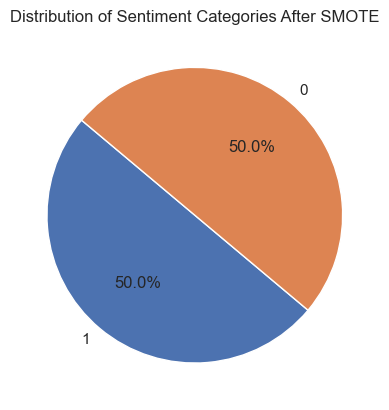

In [32]:
plt.pie(y_train_sm.value_counts(),labels=y_train_sm.unique(),autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Categories After SMOTE')
plt.show()

## Modelling & Evaluation

In [33]:
models = {
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'SVM': (SVC(probability=True,random_state=42), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    })
}

In [34]:
acc = []
f1_scores = []
precision_scores = []
recall_scores = []
cv_scores = []


Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


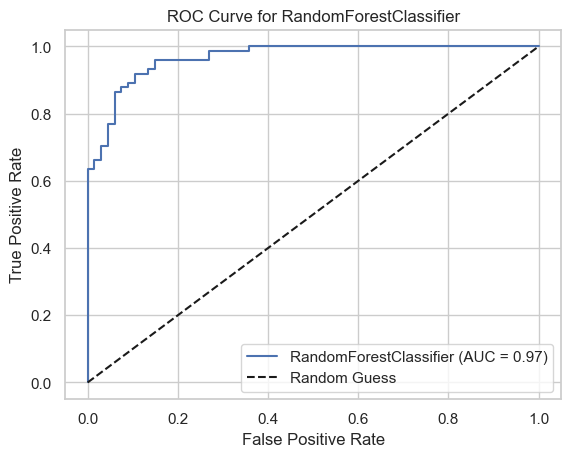

AUC Score for RandomForestClassifier: 0.97
Performing Cross-Validation for RandomForestClassifier...
Training & save model RandomForestClassifier Done.

Performing Grid Search for SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


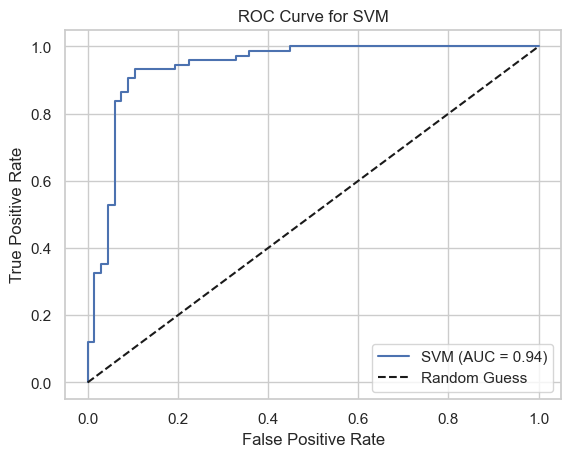

AUC Score for SVM: 0.94
Performing Cross-Validation for SVM...
Training & save model SVM Done.

Performing Grid Search for KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


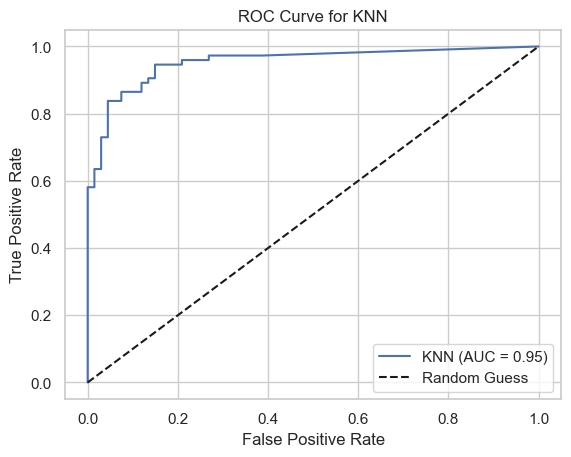

AUC Score for KNN: 0.95
Performing Cross-Validation for KNN...
Training & save model KNN Done.


In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
# Perform Grid Search and Cross-Validation for each model
for model_name, (model, param_grid) in models.items():
    print(f"\nPerforming Grid Search for {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train_sm, y_train_sm)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(sc_xtest)
    
    if hasattr(best_model, "predict_proba"):  # Pastikan model memiliki predict_proba
        y_pred_proba = best_model.predict_proba(sc_xtest)[:, 1]
        # Calculate ROC and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend(loc="lower right")
        plt.show()
        
        print(f"AUC Score for {model_name}: {auc_score:.2f}")
    else:
        print(f"{model_name} does not support probability prediction. Skipping ROC Curve.")
    
    # Cross-Validation Performance
    print(f"Performing Cross-Validation for {model_name}...")
    cv = cross_val_score(best_model, sc_xtest, y_test, cv=5, scoring='accuracy', n_jobs=-1).mean()
    cv_scores.append(cv)

    # Test Set Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    acc.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    pickle.dump(best_model, open(f'Streamlit/{model_name}.pkl', 'wb'))
    print(f'Training & save model {model_name} Done.')


In [36]:
models = [
    'RandomForestClassifier',
    'KNeighborsClassifier',
    'SVM'
]
result_model = {
    'Model': models,
    'Accuracy':acc,
    'F1_Score': f1_scores,
    'Recall': recall_scores,
    'Precisions': precision_scores,
    'Cross Validation Score (5-folds)': cv_scores
}
df_model = pd.DataFrame(result_model)

- I'm still paying attention to the accuracy score as well since this metric is easier to interpret.
- The model's performance was evaluated using metrics such as precision, recall, and F1-score.
- I'm also using cross validation performance to estimated accuracy score for data validation with 5-folds.
- In credit risk modeling, test performance is calculated using the AUC metrics.

In [37]:
df_model.sort_values(by=list(df_model.columns)[1:],ascending=False,ignore_index=True)

,Model,Accuracy,F1_Score,Recall,Precisions,Cross Validation Score (5-folds)
0,KNeighborsClassifier,0.907801,0.907662,0.907801,0.908350,0.872660
1,SVM,0.900709,0.900316,0.900709,0.903238,0.886453
2,RandomForestClassifier,0.893617,0.893456,0.893617,0.894109,0.850739


SVM give the best performance

## Conclusion

SVM is the best model, providing a strong balance with an accuracy of **0.9007**, precision of **0.9032**, recall of **0.9007**, F1-score of **0.9003**, and cross-validation performance of **0.8865**. Its consistency across folds makes it ideal for predicting new data. The model was tested using the AUC metric, achieving an impressive **0.94**, indicating excellent performance.